In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score

from scipy import stats

In [2]:
train = pd.read_csv("./data/train.csv")
train_y = train[["SALE PRICE"]]
train_X = train
del train_X["SALE PRICE"]

test_X = pd.read_csv("./data/test.csv")
test_y = pd.read_csv("./data/test_groundtruth.csv")

print("train_X:",train_X.shape)
print("train_y:",train_y.shape)
print("test_X:",test_X.shape)
print("test_y:",test_y.shape)

train_X: (43064, 19)
train_y: (43064, 1)
test_X: (10767, 19)
test_y: (10767, 1)


In [16]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE
0,1,UPPER EAST SIDE (79-96),13 CONDOS - ELEVATOR APARTMENTS,2,1569,1027,R4,402 EAST 90TH STREET,5A,10128,1,0,1,-,-,1910,2,R4,2016-09-30 00:00:00
1,4,HOLLISWOOD,10 COOPS - ELEVATOR APARTMENTS,2,10538,70,D4,"87-50 204TH STREET, B42",,11423,0,0,0,-,-,1954,2,D4,2017-02-10 00:00:00
2,3,DOWNTOWN-FULTON MALL,13 CONDOS - ELEVATOR APARTMENTS,2,170,1042,R4,265 STATE STREET,910,11201,1,0,1,0,0,2014,2,R4,2017-01-25 00:00:00
3,4,FLUSHING-NORTH,13 CONDOS - ELEVATOR APARTMENTS,2,4410,1023,R4,137-11 32 AVENUE,4W,11354,1,0,1,-,-,0,2,R4,2017-03-17 00:00:00
4,3,PARK SLOPE,09 COOPS - WALKUP APARTMENTS,2C,1067,29,C6,"862 PRESIDENT STREET, 1",,11215,0,0,0,0,0,1920,2,C6,2016-09-09 00:00:00


In [146]:

# print(train["BUILDING CLASS AT TIME OF SALE"].value_counts())
# print(train["BUILDING CLASS AT TIME OF SALE"].value_counts())
# print(train["NEIGHBORHOOD"].value_counts())

# print(train["BUILDING CLASS CATEGORY"].value_counts())
# train["SALE MONTH"]=train["SALE DATE"].transform(lambda x: int(x.split("-")[1]))
# train["SALE YEAR"]=train["SALE DATE"].transform(lambda x: int(x.split("-")[0]))
# print(train["SALE MONTH"].value_counts())
# print(train["SALE YEAR"].value_counts())

6     4340
9     3896
3     3875
12    3854
5     3803
7     3466
1     3455
11    3438
10    3336
8     3229
4     3200
2     3172
Name: SALE MONTH, dtype: int64


In [3]:
num_train_samples = len(train_X)

data_X = pd.concat([train_X, test_X])
print(data_X.shape)

(53831, 19)


 -      15521
0        6084
2000     1848
2500     1649
4000     1446
1800      602
3000      575
5000      448
2400      259
1900      240
Name: LAND SQUARE FEET, dtype: int64
0       21605
2000     1848
2500     1649
4000     1446
1800      602
3000      575
5000      448
2400      259
1900      240
6000      222
Name: LAND SQUARE FEET, dtype: int64


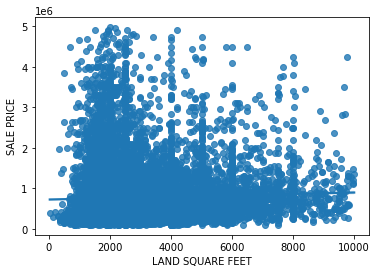

In [4]:
## 为了更好的特征工程，得先看一下数据
train = pd.read_csv("./data/train.csv")
# train.groupby("GROSS SQUARE FEET")["SALE PRICE"].agg(["mean", "count", "median"]).sort_values(by="mean",ascending=False)
print(train["LAND SQUARE FEET"].value_counts().sort_values(ascending=False).head(10))
train["LAND SQUARE FEET"].replace(" -  ","0",inplace=True)
train["LAND SQUARE FEET"] = train["LAND SQUARE FEET"].astype("int64")
print(train["LAND SQUARE FEET"].value_counts().sort_values(ascending=False).head(10))
sns.regplot(x="LAND SQUARE FEET",y="SALE PRICE",data=train[train["LAND SQUARE FEET"]!=0])
# sns.regplot(x="GROSS SQUARE FEET",y="SALE PRICE",data=train[train["GROSS SQUARE FEET"]!=0])
# train["GROSSSQUAREFEETCut"] = pd.qcut(train[train["LAND SQUARE FEET"]!=0]["GROSS SQUARE FEET"], q=10)
med=train[train["LAND SQUARE FEET"]!=0]["LAND SQUARE FEET"].median() #2500

# # 保留LAND SQUARE FEET
data_X["LAND SQUARE FEET"] = data_X["LAND SQUARE FEET"].replace(" -  ","0")
data_X["LAND SQUARE FEET"] = data_X["LAND SQUARE FEET"].astype("int64")
data_X["LAND SQUARE FEET"] = data_X["LAND SQUARE FEET"].replace(0,med) #用中位数填充0 最后证明并没有效果

 -      15816
0        6353
1440      188
1600      184
2000      180
Name: GROSS SQUARE FEET, dtype: int64
Index([' -  ', '0', '1440', '1600', '2000', '1800', '2400', '1280', '1200',
       '1224',
       ...
       '908', '4128', '983', '3205', '665', '3677', '546', '3981', '6895',
       '2758'],
      dtype='object', length=3093)
0       22169
1440      188
1600      184
2000      180
2400      175
Name: GROSS SQUARE FEET, dtype: int64


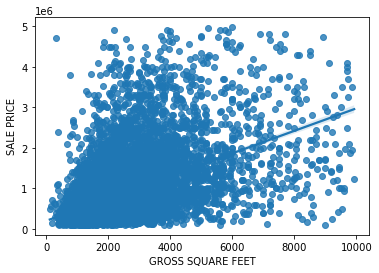

In [5]:
train = pd.read_csv("./data/train.csv")
print(train["GROSS SQUARE FEET"].value_counts().sort_values(ascending=False).head(5))
print(train["GROSS SQUARE FEET"].value_counts().sort_values(ascending=False).index) # 发现' -  '是str类型直接替换成'0'
train["GROSS SQUARE FEET"].replace(' -  ', '0', inplace=True)
print(train["GROSS SQUARE FEET"].value_counts().sort_values(ascending=False).head(5))
train["GROSS SQUARE FEET"] = train["GROSS SQUARE FEET"].astype("int64")
sns.regplot(x="GROSS SQUARE FEET",y="SALE PRICE",data=train[train["GROSS SQUARE FEET"]!=0])
med2=train[train["GROSS SQUARE FEET"]!=0]["GROSS SQUARE FEET"].median() # 1800
# 保留GROSS SQUARE FEET
data_X["GROSS SQUARE FEET"] = data_X["GROSS SQUARE FEET"].replace(" -  ","0")
data_X["GROSS SQUARE FEET"] = data_X["GROSS SQUARE FEET"].astype("int64")
data_X["GROSS SQUARE FEET"] = data_X["GROSS SQUARE FEET"].replace(0,med2) #用中位数填充0 最后证明并没有效果

In [54]:
train["SALE PRICE"].isnull().sum()

0

<AxesSubplot:xlabel='YEAR BUILT', ylabel='SALE PRICE'>

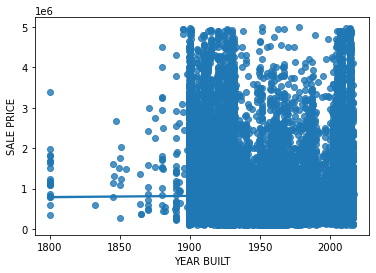

In [26]:
sns.regplot(x=train["YEAR BUILT"][train["YEAR BUILT"] !=0 ],y=train["SALE PRICE"][train["YEAR BUILT"] !=0 ])

<AxesSubplot:xlabel='SALE MONTH', ylabel='SALE PRICE'>

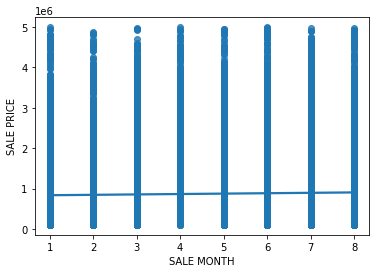

In [167]:
train["SALE MONTH"]=train["SALE DATE"].transform(lambda x: int(x.split("-")[1]))
train["SALE YEAR"]=train["SALE DATE"].transform(lambda x: int(x.split("-")[0]))
sns.regplot(x="SALE MONTH",y="SALE PRICE",data=train[train["SALE YEAR"]==2017])

# Data Pre Processing

In [6]:
# Let's delete some of the columns that we ** may not ** need
# 请注意 下面删除的特征很可能是有用的，合理的处理能够获得更为准确的预测模型，请探索所删除特征的使用
del data_X['ADDRESS']
del data_X['APARTMENT NUMBER'] # 数据字典没找到
del data_X['BUILDING CLASS AT PRESENT'] #BUILDCLASS都加了理论上应该加 一共有114种
del data_X['BUILDING CLASS AT TIME OF SALE'] #BUILDCLASS都加了理论上应该加 一共有113种
# del data_X['NEIGHBORHOOD'] # NEIGHBORHOOD相关性貌似很高 但有 249种
del data_X['SALE DATE'] # 应该和yearbuilt类似 不过SALE DATE种类比较多
# del data_X['LAND SQUARE FEET'] # 这个大小很关键啊
# del data_X['GROSS SQUARE FEET'] # 这个大小很关键啊

In [7]:
# Let's convert some of the columns to appropriate datatype

data_X['TAX CLASS AT TIME OF SALE'] = data_X['TAX CLASS AT TIME OF SALE'].astype('category')
data_X['TAX CLASS AT PRESENT'] = data_X['TAX CLASS AT PRESENT'].astype('category')
data_X['BOROUGH'] = data_X['BOROUGH'].astype('category')
# data_X['BUILDING CLASS CATEGORY'] = data_X['BUILDING CLASS CATEGORY'].astype('category')
# data_X['BUILDING CLASS AT TIME OF SALE'] = data_X['BUILDING CLASS AT TIME OF SALE'].astype('category')
# data_X['BUILDING CLASS AT PRESENT'] = data_X['BUILDING CLASS AT PRESENT'].astype('category')


In [125]:
data_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53831 entries, 0 to 10766
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         53831 non-null  category
 1   NEIGHBORHOOD                    53831 non-null  object  
 2   BUILDING CLASS CATEGORY         53831 non-null  object  
 3   TAX CLASS AT PRESENT            53831 non-null  category
 4   BLOCK                           53831 non-null  int64   
 5   LOT                             53831 non-null  int64   
 6   BUILDING CLASS AT PRESENT       53831 non-null  category
 7   ZIP CODE                        53831 non-null  int64   
 8   RESIDENTIAL UNITS               53831 non-null  int64   
 9   COMMERCIAL UNITS                53831 non-null  int64   
 10  TOTAL UNITS                     53831 non-null  int64   
 11  LAND SQUARE FEET                53831 non-null  int64   
 12  GROSS SQUARE FEET 

In [70]:
data_X.head()

,BOROUGH,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
0,1,13 CONDOS - ELEVATOR APARTMENTS,2,1569,1027,R4,10128,1,0,1,2500,1800,1910,2,R4
1,4,10 COOPS - ELEVATOR APARTMENTS,2,10538,70,D4,11423,0,0,0,2500,1800,1954,2,D4
2,3,13 CONDOS - ELEVATOR APARTMENTS,2,170,1042,R4,11201,1,0,1,2500,1800,2014,2,R4
3,4,13 CONDOS - ELEVATOR APARTMENTS,2,4410,1023,R4,11354,1,0,1,2500,1800,0,2,R4
4,3,09 COOPS - WALKUP APARTMENTS,2C,1067,29,C6,11215,0,0,0,2500,1800,1920,2,C6


In [8]:
#Select the variables to be one-hot encoded
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE', "NEIGHBORHOOD"]

In [9]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(data_X[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53831 entries, 0 to 10766
Data columns (total 310 columns):
 #    Column                                                                Non-Null Count  Dtype
---   ------                                                                --------------  -----
 0    BOROUGH_1                                                             53831 non-null  uint8
 1    BOROUGH_2                                                             53831 non-null  uint8
 2    BOROUGH_3                                                             53831 non-null  uint8
 3    BOROUGH_4                                                             53831 non-null  uint8
 4    BOROUGH_5                                                             53831 non-null  uint8
 5    BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                       53831 non-null  uint8
 6    BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                       53831 non-null  uint8
 7    BU

In [10]:
data_X = data_X.drop(one_hot_features,axis=1)
data_X = pd.concat([data_X, one_hot_encoded] ,axis=1)

In [74]:
data_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53831 entries, 0 to 10766
Columns: 297 entries, BLOCK to BUILDING CLASS AT TIME OF SALE_Z9
dtypes: int64(9), uint8(288)
memory usage: 18.9 MB


In [11]:
train_X = data_X[:num_train_samples].to_numpy()
test_X = data_X[num_train_samples:].to_numpy()

,SALE PRICE
0,2.49977
1,23.60248
2,3.45000
3,3.00000
4,3.90000
...,...
10762,24.20000
10763,4.40000
10764,3.37000
10765,4.65000


In [ ]:
# 简单加入LAND SQUARE FEET GROSS SQUARE FEET两个特征 从0.368提升到0.354
# 以上两特征用中位数填充原本为0的空缺 效果几乎没变化
# 粗暴地加BUILDING CLASS 直接one hot 效果几乎没变化
# 粗暴地加NEIGHBORHOOD 效果从0.354提到0.35
# SLAE DATE -> SALE MONTH one-hot分十二个月 但是只加入月份信息，效果反而下降，猜测需要加入年份才能提升，
# 猜错了16年 9-12月 17年1-8月 月份信息就是不显著 会干扰判断 不加入
# 改变预测模型 不如RandomForest


# Regression

In [181]:

rf_regr = RandomForestRegressor()
rf_regr.fit(train_X, train_y)
Y_pred_rf = rf_regr.predict(test_X)
mean_absolute_percentage_error(test_y,Y_pred_rf)

0.3493692514331562

In [12]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
models = [LinearRegression(),Ridge(), Lasso(alpha=0.01,max_iter=10000), RandomForestRegressor(), GradientBoostingRegressor(), SVR(), LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000), SGDRegressor(max_iter=1000,tol=1e-3), BayesianRidge(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(), XGBRegressor()] 
regr2=XGBRegressor()
regr2.fit(train_X, train_y)
Y_pred_rf2 = regr2.predict(test_X)
mean_absolute_percentage_error(test_y,Y_pred_rf2)

0.3938888724577178

In [16]:
regr2=RandomForestRegressor()
regr2.fit(train_X, train_y)
Y_pred_rf2 = regr2.predict(test_X)
mean_absolute_percentage_error(test_y,Y_pred_rf2)

0.3504110975405621

In [ ]:
# class grid():
#     def __init__(self,model):
#         self.model = model
    
#     def grid_get(self,X,y,param_grid):
#         grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
#         grid_search.fit(X,y)
#         print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
#         grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
#         print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])
# grid(Lasso()).grid_get(train_X, train_y, {'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})

In [184]:
# import time 
# models = [Lasso(alpha=0.01,max_iter=10000), RandomForestRegressor(), GradientBoostingRegressor(), LinearSVR(),
#           ElasticNet(alpha=0.001,max_iter=10000), SGDRegressor(max_iter=1000,tol=1e-3), BayesianRidge(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
#           ExtraTreesRegressor(), XGBRegressor(), SVR()] 
# for model in models:
#     start = time.time()
#     model.fit(train_X, train_y)
#     pred=model.predict(test_X)
#     print(mean_absolute_percentage_error(test_y,pred))
#     print(time.time()-start)

In [15]:
# pd.DataFrame({"pred":Y_pred_rf}).to_csv("学号_姓名.csv")

## 以下是DNN的尝试，除了困惑啥也没带来

In [ ]:
# 猜测 预测不好的原因是输入x和尤其是y没归一太大了。
# 猜测正确 除scale后好了很多
# 很奇怪 为啥shuffle之后结果变得随机
# 随机初始化对结果的影响也很大
# 另外加了特征RandomForest变好了，DNN却变差了

In [55]:
import torch
import torch.utils.data as data
class Net(torch.nn.Module):
    def __init__(self, in_dims, out_dims):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_dims, in_dims*2)
        self.bn1 = torch.nn.BatchNorm1d(in_dims*2)
        self.fc2 = torch.nn.Linear(in_dims*2, in_dims)
        self.bn2 = torch.nn.BatchNorm1d(in_dims)
        self.fc3 = torch.nn.Linear(in_dims, 64)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.fc4 = torch.nn.Linear(64, 32)
        self.bn4 = torch.nn.BatchNorm1d(32)
        self.fc5 = torch.nn.Linear(32, out_dims)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
criterion = torch.nn.MSELoss()
model=Net(train_X.shape[1],1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-5)
class MyDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)
# print(len(train_X))
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor((train_y).to_numpy(), dtype=torch.float32)
train_dataset = MyDataset(train_X_tensor, train_y_tensor)
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=False)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
# test_y_tensor = torch.tensor(test_y.to_numpy(), dtype=torch.float32)
# test_dataset = MyDataset(test_X_tensor, test_y_tensor)
# test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)

for e in range(100):
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    print('epoch: {}, loss: {:.4}'.format(e, loss.item()))
    scheduler.step()
    # start validation
    with torch.no_grad():
        model.eval()
        val_loss = 0
        y_pred = model(test_X_tensor)
        print(mean_absolute_percentage_error(test_y,y_pred.detach().numpy()))
        # for X, y in test_loader:
        #     y_pred = model(X)
        #     val_loss += criterion(y_pred, y).item()
        # print('epoch: {}, val loss: {:.4}'.format(e, val_loss))

    



epoch: 0, loss: 99.39
0.763133144713823
epoch: 1, loss: 41.91
0.5361471216219795
epoch: 2, loss: 39.08
0.530916649691487
epoch: 3, loss: 38.75
0.5187646412025461
epoch: 4, loss: 37.59
0.5122975194633751
epoch: 5, loss: 36.71
0.5097226334817039
epoch: 6, loss: 36.21
0.5067895929390447
epoch: 7, loss: 35.96
0.49899552497530797
epoch: 8, loss: 35.81
0.49514823570538413
epoch: 9, loss: 35.94
0.491226402702627
epoch: 10, loss: 36.24
0.48982744038466275
epoch: 11, loss: 37.3
0.4811273875444861
epoch: 12, loss: 37.58
0.486939091563459
epoch: 13, loss: 39.44
0.47608084685592494
epoch: 14, loss: 39.68
0.4752117066061081
epoch: 15, loss: 39.28
0.4802043513304233
epoch: 16, loss: 40.12
0.47039345401370575
epoch: 17, loss: 40.94
0.46914909126756954
epoch: 18, loss: 40.41
0.4699705421100537
epoch: 19, loss: 40.05
0.4688733223567074
epoch: 20, loss: 43.74
0.46489364345035084
epoch: 21, loss: 40.98
0.465055065339073
epoch: 22, loss: 41.39
0.4671802993924935
epoch: 23, loss: 40.43
0.4599561328266199
e

In [52]:
for child in model.children():
    print(child)
    for param in child.parameters():
        print(param)

Linear(in_features=66, out_features=132, bias=True)
Parameter containing:
tensor([[ 8.3238e-02, -1.2507e-01,  2.5693e-02,  ...,  6.6218e-01,
         -1.0672e+00, -4.0593e-02],
        [-1.1108e-01, -2.0265e-02, -2.3722e-02,  ...,  3.2508e-01,
         -5.5617e-01,  1.2300e+00],
        [-4.1121e-02,  3.1138e-02, -2.0625e-03,  ...,  1.0087e+00,
         -5.3241e-01,  1.5579e-01],
        ...,
        [-1.1768e-02, -1.0776e-01, -5.5719e-02,  ...,  7.1429e-01,
         -2.5528e-01, -1.7045e-01],
        [ 3.7716e-02,  5.5596e-02, -2.1820e-02,  ..., -1.0751e-01,
          5.8591e-01, -9.4843e-01],
        [ 9.6331e-02, -1.9863e-03, -1.9136e-02,  ..., -4.6681e-01,
          2.6660e+00, -2.2090e+00]], requires_grad=True)
Parameter containing:
tensor([-1.2897e-02, -1.4888e-02, -4.0455e-03, -4.8760e-03, -1.9177e-02,
         1.1223e-02, -5.2030e-03, -3.9466e-02, -4.3858e-02,  7.8715e-03,
        -4.1828e-03, -3.4883e-03, -9.7619e-04,  3.7989e-03, -1.6330e-02,
        -1.1495e-02, -8.0935e-03,

In [54]:
for child in model.children():
    print(child)
    for param in child.parameters():
        print(param)

Linear(in_features=66, out_features=132, bias=True)
Parameter containing:
tensor([[-1.2146e-01,  9.3741e-02, -9.3805e-02,  ...,  6.9662e-02,
         -4.8433e-01,  1.4670e+00],
        [-9.0386e-02, -5.7977e-02,  5.1542e-02,  ...,  7.8222e-01,
         -7.1515e-01,  8.5731e-01],
        [-1.6872e-01,  1.0400e-01,  2.2599e-02,  ..., -3.4226e-01,
          1.3034e-03,  3.0069e-01],
        ...,
        [-1.5535e-01, -8.8594e-03,  5.8788e-02,  ...,  1.1933e-01,
          8.3830e-02, -3.5050e-01],
        [ 1.1786e-01, -4.5568e-02, -7.1225e-02,  ...,  5.8582e-01,
         -5.4140e-02, -6.3760e-01],
        [ 4.3733e-03,  1.5131e-01,  3.9635e-02,  ..., -6.1774e-01,
          4.4557e-01, -6.0694e-01]], requires_grad=True)
Parameter containing:
tensor([-1.2174e-02, -1.2185e-02,  2.4916e-02, -1.1692e-02, -3.6882e-03,
        -2.9203e-02, -2.1429e-02, -4.5044e-03, -2.0736e-02,  2.1442e-06,
        -1.8871e-02, -1.5301e-02,  1.9525e-02, -3.7168e-02,  3.7892e-03,
         8.4691e-03, -1.5854e-02,

In [ ]:
# import torch
# class Net(torch.nn.Module):
#     def __init__(self, in_dims, out_dims):
#         super(Net, self).__init__()
#         self.fc1 = torch.nn.Linear(in_dims, in_dims*2)
#         self.fc2 = torch.nn.Linear(in_dims*2, in_dims)
#         self.fc3 = torch.nn.Linear(in_dims, 64)
#         self.fc4 = torch.nn.Linear(64, 32)
#         self.fc5 = torch.nn.Linear(32, out_dims)
#         self.relu = torch.nn.ReLU()
#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.fc5(self.relu(self.fc4(self.relu(self.fc3(x)))))
#         return x
# criterion = torch.nn.MSELoss()


# out = model(var_x)
#     loss = criterion(out, var_y)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
#     # start validation
#     var_val_x = torch.tensor(test_X, dtype=torch.float32)
#     pred_y = model(var_val_x)
#     print(mean_absolute_percentage_error(test_y,pred_y.detach().numpy()))

In [57]:
# # 无batchnorm
# import torch
# import torch.utils.data as data
# class Net(torch.nn.Module):
#     def __init__(self, in_dims, out_dims):
#         super(Net, self).__init__()
#         self.fc1 = torch.nn.Linear(in_dims, in_dims*2)
#         self.bn1 = torch.nn.BatchNorm1d(in_dims*2)
#         self.fc2 = torch.nn.Linear(in_dims*2, in_dims)
#         self.bn2 = torch.nn.BatchNorm1d(in_dims)
#         self.fc3 = torch.nn.Linear(in_dims, 64)
#         self.bn3 = torch.nn.BatchNorm1d(64)
#         self.fc4 = torch.nn.Linear(64, 32)
#         self.bn4 = torch.nn.BatchNorm1d(32)
#         self.fc5 = torch.nn.Linear(32, out_dims)
#         self.relu = torch.nn.ReLU()
#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.relu(self.fc4(x))
#         x = self.fc5(x)
#         return x
# criterion = torch.nn.MSELoss()
# model=Net(train_X.shape[1],1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-5)
# class MyDataset(data.Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y
#     def __getitem__(self, index):
#         return self.X[index], self.y[index]
#     def __len__(self):
#         return len(self.X)
# # print(len(train_X))
# scale=100000
# train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
# train_y_tensor = torch.tensor((train_y/scale).to_numpy(), dtype=torch.float32)
# train_dataset = MyDataset(train_X_tensor, train_y_tensor)
# train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=False)
# test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
# # test_y_tensor = torch.tensor(test_y.to_numpy(), dtype=torch.float32)
# # test_dataset = MyDataset(test_X_tensor, test_y_tensor)
# # test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# for e in range(100):
#     for i, (X, y) in enumerate(train_loader):
#         optimizer.zero_grad()
#         y_pred = model(X)
#         loss = criterion(y_pred, y)
#         loss.backward()
#         optimizer.step()
#     print('epoch: {}, loss: {:.4}'.format(e, loss.item()))
#     scheduler.step()
#     # start validation
#     with torch.no_grad():
#         model.eval()
#         val_loss = 0
#         y_pred = model(test_X_tensor)
#         print(mean_absolute_percentage_error(test_y,scale*y_pred.detach().numpy()))
#         # for X, y in test_loader:
#         #     y_pred = model(X)
#         #     val_loss += criterion(y_pred, y).item()
#         # print('epoch: {}, val loss: {:.4}'.format(e, val_loss))

    



epoch: 0, loss: 47.93
0.6045128062851417
epoch: 1, loss: 45.64
0.5739716675052394
epoch: 2, loss: 44.71
0.566989761434227
epoch: 3, loss: 43.55
0.5631242270390654
epoch: 4, loss: 42.81
0.5685382748843975
epoch: 5, loss: 42.17
0.552807999609689
epoch: 6, loss: 41.37
0.5592175839761868
epoch: 7, loss: 40.86
0.5480322556588834
epoch: 8, loss: 40.32
0.5490100439144388
epoch: 9, loss: 40.39
0.5445327672107626
epoch: 10, loss: 39.67
0.5430639234099014
epoch: 11, loss: 39.25
0.540566374013597
epoch: 12, loss: 39.5
0.5404298146558697
epoch: 13, loss: 39.34
0.5391038851900117
epoch: 14, loss: 39.06
0.5383232780427731
epoch: 15, loss: 38.88
0.537724460691
epoch: 16, loss: 38.82
0.5362065294870225
epoch: 17, loss: 38.77
0.5361081222588694
epoch: 18, loss: 38.54
0.5333803629713869
epoch: 19, loss: 38.32
0.5288716574260729
epoch: 20, loss: 37.92
0.5235171907787339
epoch: 21, loss: 38.19
0.5248706062515384
epoch: 22, loss: 38.45
0.5242448907733397
epoch: 23, loss: 38.21
0.5208662373400194
epoch: 24,

# 其实以上都可以不看，以下摘自树洞#5101417，太强了，很惭愧：

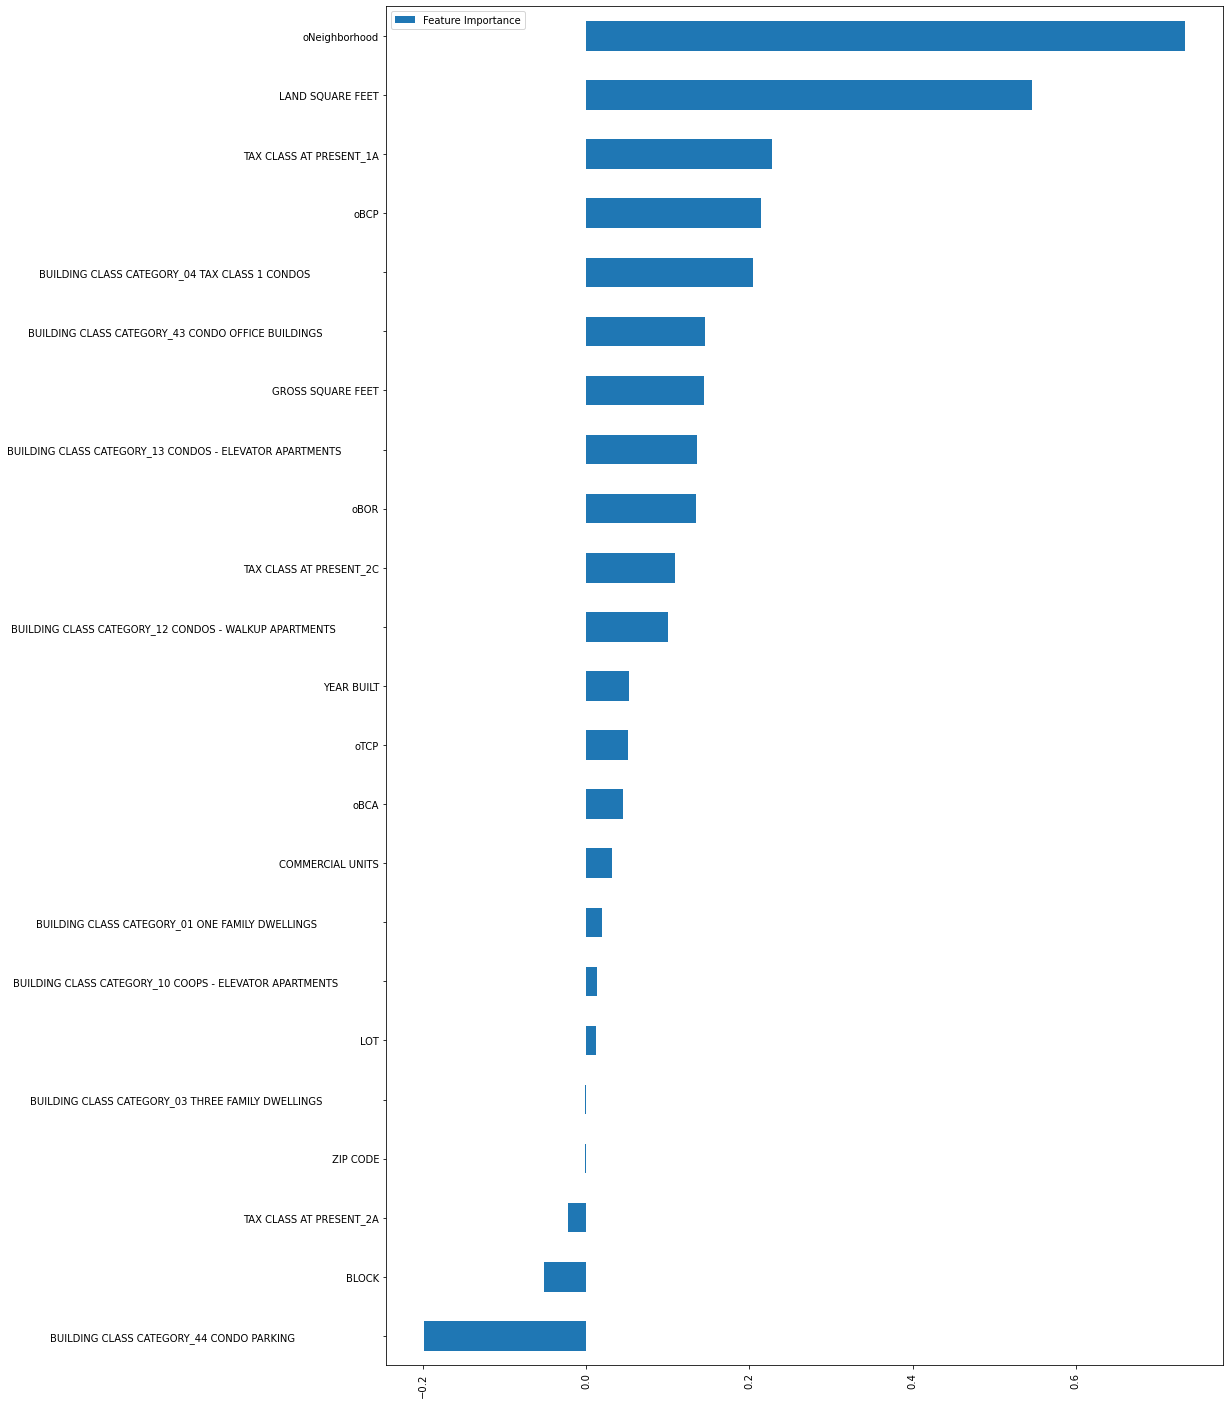

0.31268475710092564

In [1]:

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor
train = pd.read_csv("./data/train.csv")
train_y = train["SALE PRICE"]
train_X = train
# del train_X["SALE PRICE"]

test_X = pd.read_csv("./data/test.csv")
test_y = pd.read_csv("./data/test_groundtruth.csv")
num_train_samples = len(train_X)

full = pd.concat([train_X, test_X])

full.drop(['ADDRESS'], axis=1, inplace=True)
full.drop(['APARTMENT NUMBER'], axis=1, inplace=True)
full.drop(['SALE DATE'], axis=1, inplace=True)

full['LAND SQUARE FEET'] = full['LAND SQUARE FEET'].transform(lambda x: 0 if x == ' -  ' else float(x))
full['GROSS SQUARE FEET'] = full['GROSS SQUARE FEET'].apply(lambda x: 0 if x == ' -  ' else float(x))


verNei = train_X.groupby(['NEIGHBORHOOD'])[['SALE PRICE']].agg(['mean'])
dNei = dict(dict(verNei[('SALE PRICE', 'mean')]))
verBOR = train_X.groupby(['BOROUGH'])[['SALE PRICE']].agg(['mean'])
dBOR = dict(verBOR[('SALE PRICE', 'mean')])
verBCP = train_X.groupby(['BUILDING CLASS AT PRESENT'])[['SALE PRICE']].agg(['mean'])
dBCP = dict(verBCP[('SALE PRICE', 'mean')])
verBCA = train_X.groupby(['BUILDING CLASS AT TIME OF SALE'])[['SALE PRICE']].agg(['mean'])
dBCA = dict(verBCA[('SALE PRICE', 'mean')])
verTCP = train_X.groupby(['TAX CLASS AT PRESENT'])[['SALE PRICE']].agg(['mean'])
dTCP = dict(verTCP[('SALE PRICE', 'mean')])
verTCA = train_X.groupby(['TAX CLASS AT TIME OF SALE'])[['SALE PRICE']].agg(['mean'])
dTCA = dict(verTCA[('SALE PRICE', 'mean')])

full["oNeighborhood"] = full["NEIGHBORHOOD"].map(dNei).fillna(1).apply(np.log)
full["oBOR"] = full["BOROUGH"].map(dBOR).fillna(1).apply(np.log)
full["oBCA"] = full["BUILDING CLASS AT TIME OF SALE"].map(dBCA).fillna(1).apply(np.log)
full["oBCP"] = full["BUILDING CLASS AT PRESENT"].map(dBCP).fillna(1).apply(np.log)
full["oTCA"] = full["BUILDING CLASS AT TIME OF SALE"].map(dTCA).fillna(1).apply(np.log)
full["oTCP"] = full["BUILDING CLASS AT PRESENT"].map(dTCP).fillna(1).apply(np.log)
full["oBCC"] = full["BUILDING CLASS CATEGORY"].map(dTCP).fillna(1).apply(np.log)
# one_hot_features = ['BOROUGH']
# one_hot_encoded = pd.get_dummies(full[one_hot_features])
# one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)
# full = pd.concat([full, one_hot_encoded] ,axis=1)
full.drop(['BOROUGH'], axis=1, inplace=True)
full.drop(['BUILDING CLASS AT TIME OF SALE'], axis=1, inplace=True)
full.drop(['BUILDING CLASS AT PRESENT'], axis=1, inplace=True)
full.drop(['NEIGHBORHOOD'], axis=1, inplace=True)


NumStr = [
    "YEAR BUILT",
    "TAX CLASS AT PRESENT",
    "TAX CLASS AT TIME OF SALE",
    "BUILDING CLASS CATEGORY",
    ]
for col in NumStr:
    full[col] = full[col].astype(str)

full.drop(['SALE PRICE'], axis=1, inplace=True)


class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lab = LabelEncoder()
        X["YEAR BUILT"] = lab.fit_transform(X["YEAR BUILT"])
        return X

class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self, skew=0.5):
        self.skew = skew

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_numeric = X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))

        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
])


full2 = full.copy()
data_pipe = pipe.fit_transform(full2)

scaler = RobustScaler()  # 对数据进行缩放

n_train = train.shape[0]  # 获得有多少条训练数据

X = data_pipe[:n_train]  # 获得训练数据
test_X = data_pipe[n_train:]  # 获得测试数据
y = train_y
X_scaled = scaler.fit(X).transform(X)
y_log = np.log(y)  # 对于 y 进行人为定义log 进行缩放
test_X_scaled = scaler.transform(test_X)  # 对测试数据进行缩放

# ## Feature Selection

# + __上面的特征工程还不够，所以我们需要更多.__   
# + __组合不同的特征通常是一个好方法，但我们不知道应该选择什么特征。 幸运的是，有些模型可以提供特征选择，这里我使用 Lasso，但你可以自由选择 Ridge、RandomForest 或 GradientBoostingTree.__

lasso = Lasso(alpha=0.001)
lasso.fit(X_scaled, y_log)  # 用lasso 拟合 缩放后的训练数据 和 对应的 y 值

# In[ ]:


FI_lasso = pd.DataFrame({"Feature Importance": lasso.coef_}, index=data_pipe.columns)

# In[ ]:


FI_lasso.sort_values("Feature Importance", ascending=False)  # 利用Lasso计算出一个特征重要性的分数

# In[ ]:


FI_lasso[FI_lasso["Feature Importance"] != 0].sort_values("Feature Importance").plot(kind="barh", figsize=(15, 25))
plt.xticks(rotation=90)
plt.show()  ### 更直观的可视化一下

class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self, mod, weight):
        self.mod = mod
        self.weight = weight

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X, y)
        return self

    def predict(self, X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model, data] * weight for model, weight in zip(range(pred.shape[0]), self.weight)]
            w.append(np.sum(single))
        return w


weight_avg = AverageWeight(mod=[RandomForestRegressor(), XGBRegressor(), ExtraTreesRegressor()], weight=[0.4,0.4,0.2])

weight_avg.fit(X_scaled, y_log)
y = weight_avg.predict(test_X_scaled)
y_pred = np.exp(y)
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test_y,y_pred)

In [10]:
test_y

,SALE PRICE
0,249977
1,2360248
2,345000
3,300000
4,390000
...,...
10762,2420000
10763,440000
10764,337000
10765,465000


## 不信邪地把这样处理过的70维特征放进DNN，效果还是远不如RandomForest，又是除了困惑啥都没带来

In [13]:
# 无batchnorm
train_X = X_scaled.astype(np.float32)
train_y = train["SALE PRICE"]
test_X = test_X_scaled.astype(np.float32)
test_y = pd.read_csv("./data/test_groundtruth.csv")
import torch
import torch.utils.data as data
class Net(torch.nn.Module):
    def __init__(self, in_dims, out_dims):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_dims, in_dims*2)
        self.bn1 = torch.nn.BatchNorm1d(in_dims*2)
        self.fc2 = torch.nn.Linear(in_dims*2, in_dims)
        self.bn2 = torch.nn.BatchNorm1d(in_dims)
        self.fc3 = torch.nn.Linear(in_dims, 64)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.fc4 = torch.nn.Linear(64, 32)
        self.bn4 = torch.nn.BatchNorm1d(32)
        self.fc5 = torch.nn.Linear(32, out_dims)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
scale = 100000
criterion = torch.nn.MSELoss()
model=Net(train_X.shape[1],1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-5)
class MyDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)
# print(len(train_X))
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor((train_y/scale).to_numpy(), dtype=torch.float32)
train_dataset = MyDataset(train_X_tensor, train_y_tensor)
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=False)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
# test_y_tensor = torch.tensor(test_y.to_numpy(), dtype=torch.float32)
# test_dataset = MyDataset(test_X_tensor, test_y_tensor)
# test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)

for e in range(100):
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X)
        y_pred = y_pred.squeeze()
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    print('epoch: {}, loss: {:.4}'.format(e, loss.item()))
    scheduler.step()
    # start validation
    with torch.no_grad():
        model.eval()
        val_loss = 0
        y_pred = model(test_X_tensor)
        print(mean_absolute_percentage_error(test_y,scale*y_pred.detach().numpy()))
        # for X, y in test_loader:
        #     y_pred = model(X)
        #     val_loss += criterion(y_pred, y).item()
        # print('epoch: {}, val loss: {:.4}'.format(e, val_loss))

    



epoch: 0, loss: 37.35
0.47588765890397644
epoch: 1, loss: 25.42
0.4277424904917888
epoch: 2, loss: 23.49
0.42338816138026814
epoch: 3, loss: 23.07
0.42129409179417904
epoch: 4, loss: 22.81
0.4185322919432125
epoch: 5, loss: 22.64
0.409947018776567
epoch: 6, loss: 22.02
0.4093616163506463
epoch: 7, loss: 21.6
0.4043808043295586
epoch: 8, loss: 20.89
0.40526194659722425
epoch: 9, loss: 21.12
0.39984670004035816
epoch: 10, loss: 20.94
0.40153479920267793
epoch: 11, loss: 20.76
0.39794105290049797
epoch: 12, loss: 20.29
0.39825483816194845
epoch: 13, loss: 20.04
0.3977721007663896
epoch: 14, loss: 19.48
0.3958997789754679
epoch: 15, loss: 19.32
0.393617151504865
epoch: 16, loss: 18.68
0.39672901903944496
epoch: 17, loss: 18.15
0.39315402152145545
epoch: 18, loss: 18.1
0.39493440059664053
epoch: 19, loss: 17.63
0.39334488528390066
epoch: 20, loss: 17.99
0.3940315740430692
epoch: 21, loss: 18.08
0.3938129951626433
epoch: 22, loss: 18.1
0.3954143497232826
epoch: 23, loss: 18.29
0.399235941063